In [33]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from collections import namedtuple, defaultdict
from datetime import datetime
from sklearn.metrics import confusion_matrix

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns

In [34]:
def load_dataset(user_split = True):
    X_train = None
    y_train_medid = None
    y_train_subjid = None
    y_train_ts = None
    
    X_val = None
    y_val_medid = None
    y_val_subjid = None
    y_val_ts = None
    
    X_test = None
    y_test_medid = None
    y_test_subjid = None
    y_test_ts = None

    # user_split: Determines the creation of train/val/test set. In user_split, test/val users are never seen during the train. time_split randomly splits each user's chunks into train/val/test.
    if user_split:
        data_file_path = './data/Meditation/user_based_splits_with_timestamp.pkl'
    else:
        data_file_path = './data/Meditation/time_based_splits_with_timestamp.pkl'

    with open(data_file_path, 'rb') as f:
        all_data_splits = pickle.load(f)

        X_train = all_data_splits['train']['x']
        y_train_medid = all_data_splits['train']['y_med']
        y_train_subjid = all_data_splits['train']['y_subj']
        y_train_ts = all_data_splits['train']['y_ts']

        X_val = all_data_splits['val']['x']
        y_val_medid = all_data_splits['val']['y_med']
        y_val_subjid = all_data_splits['val']['y_subj']
        y_val_ts = all_data_splits['val']['y_ts']

        X_test = all_data_splits['test']['x']
        y_test_medid = all_data_splits['test']['y_med']
        y_test_subjid = all_data_splits['test']['y_subj']
        y_test_ts = all_data_splits['test']['y_ts']

    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts

In [35]:
user_split = True
X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, \
X_test, y_test_medid, y_test_subjid, y_test_ts = load_dataset(user_split)

In [36]:
shape0 = X_train.shape[0]
X_train = X_train.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
shape0 = X_val.shape[0]
X_val = X_val.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
shape0 = X_test.shape[0]
X_test = X_test.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)

X_train = X_train.reshape(X_train.shape[0], 1, 64, 64)
X_val = X_val.reshape(X_val.shape[0], 1, 64, 64)
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)

print(X_train.shape, X_val.shape, X_test.shape)

(2057, 1, 64, 64) (631, 1, 64, 64) (615, 1, 64, 64)


In [37]:
trainset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train_medid))
valset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val_medid))
testset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test_medid))

In [38]:
class ResidualBlock(nn.Module):
    # Residual block
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def get_resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResidualBlock(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(ResidualBlock(num_channels, num_channels))
    return blk


class CustomResNet:

    def __init__(self, input_size, output_size, hparams=None, model_name='ResNet'):
        b2, b3, b4, b5 = CustomResNet.get_blocks()
        b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.model = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 4))
        self.name = model_name
        return

    def get_model(self):
        return self.model

    @staticmethod
    def get_blocks():
        b2 = nn.Sequential(*get_resnet_block(64, 64, 2, first_block=True))
        b3 = nn.Sequential(*get_resnet_block(64, 128, 2))
        b4 = nn.Sequential(*get_resnet_block(128, 256, 2))
        b5 = nn.Sequential(*get_resnet_block(256, 512, 2))
        return b2, b3, b4, b5

    @staticmethod
    def get_param_ranges():
        return [{}], ['']

In [39]:
class CustomVGGNet:

    def __init__(self, input_size, output_size, hparams=None, model_name='VGGNet'):
        conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
        ratio = 4
        small_conv_arch = [(1, pair[1] // ratio) for pair in conv_arch]
        self.model = CustomVGGNet.vgg(small_conv_arch)
        self.name = model_name
        return

    def get_model(self):
        return self.model

    @staticmethod
    def vgg_block(num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layers)
    
    @staticmethod
    def vgg(conv_arch):
        conv_blks = []
        in_channels = 1
        # The convolutional part
        for (num_convs, out_channels) in conv_arch:
            conv_blks.append(CustomVGGNet.vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels

        return nn.Sequential(*conv_blks, nn.Flatten(),
            # The fully-connected part
            #(16x512 and 6272x4096)
            nn.Linear(out_channels*4, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4))

    @staticmethod
    def get_param_ranges():
        return [{}], ['']

In [40]:
class TrainPipeline:

    model_dict = {'ResNet': CustomResNet, 'ResNetEmbedder': CustomResNet, 'VGGNet': CustomVGGNet}

    def __init__(self, model_name):
        self.model_name = model_name
        self.ckpt_path = './runs/{}/ckpt/'.format(model_name)
        self.log_dir = './runs/{}/logs/'.format(model_name)
        self.figure_path = './runs/{}/figures/'.format(model_name)
        if not os.path.exists(self.figure_path):
            os.makedirs(self.figure_path)
        if not os.path.exists(self.ckpt_path):
            os.makedirs(self.ckpt_path)
        return
    
    def init_model(self, input_size, output_size, hparams):
        self.model = TrainPipeline.model_dict[self.model_name](input_size, output_size, hparams=hparams, model_name=self.model_name)
        if self.model_name.startswith('ResNet') or self.model_name.startswith('VGGNet'):
            return self.model.get_model()

        print("MODEL SUMMARY: ")
        self.print_model_summary()
        return self.model

    def print_model_summary(self):
        print(self.model)
        return
     
    def get_model(self):
        return self.model

    def get_embeddings(self, x_inp):
        feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
        for param in feature_extractor.parameters():
            param.requires_grad = False
            output = feature_extractor(x_inp) # output now has the features corresponding to input x
        print(output.shape)
        return output

    def compute_correct_intersection(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def random_search_cv(self, input_size, output_size, self_supervision=False, augment=False):
        
        self.device = ("cuda" if torch.cuda.is_available() else "cpu")
        epochs = 30

        hp_space, hparam_names = TrainPipeline.model_dict[self.model_name].get_param_ranges()
        learning_rate_space = [0.1] #[0.001, 0.01, 0.1]
        batch_size_space = [64] #[16, 64, 128]
        optimizer_space = [torch.optim.SGD]#, torch.optim.Adam]

        all_test_loss_trackers = {}

        for lr in learning_rate_space:
            for bs in batch_size_space:
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
                valloader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True, num_workers=0)
                testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=True, num_workers=0)
                for opti in optimizer_space:
                    for hps in hp_space:
                        self.model = self.init_model(input_size, output_size, hps).to(self.device)

                        if opti == torch.optim.SGD:
                            optimizer = opti(self.model.parameters(), lr=lr, momentum=0.9)
                        else:
                            optimizer = opti(self.model.parameters(), lr=lr)
                        
                        criterion = torch.nn.CrossEntropyLoss()
                        hparam_comment = f' batch_size={bs} lr={lr} opt={opti}'
                        tb = SummaryWriter(self.log_dir + '/' + hparam_comment)

                        hparam_key_test_monitor = 'lr={}$bs={}$opt={}$'.format(str(lr), str(bs), str(opti.__module__.split(".")[-1]))
                        model_specific_keys = ""
                        for hname in hparam_names:
                            if hname in hps:
                                model_specific_keys += "{}={}$".format(hname, str(hps[hname]))
                        hparam_key_test_monitor += model_specific_keys

                        for ep_idx in range(epochs):
                            # TRAIN BATCH STEP
                            total_loss = 0
                            total_correct = 0
                            self.model.train()
                                
                            for i, data in enumerate(trainloader):
                                # Every data instance is an input + label pair
                                inputs, labels = data
                                labels = labels.type(torch.LongTensor)

                                inputs, labels = inputs.to(self.device), labels.to(self.device)

                                # Zero your gradients for every batch!
                                optimizer.zero_grad()

                                # Make predictions for this batch
                                output_preds = self.model(inputs)

                                # Compute the loss and its gradients
                                loss = criterion(output_preds, labels)
                                total_loss+= loss.item()
                                loss.backward()

                                # Adjust learning weights
                                optimizer.step()
                                
                                total_correct+= self.compute_correct_intersection(output_preds, labels)
                            
                            # VALIDATION STEP
                            total_val_loss = 0.0
                            total_val_correct = 0
                            self.model.eval()
                            with torch.no_grad():
                                for j, vdata in enumerate(valloader):
                                    vinputs, vlabels = vdata
                                    vlabels = vlabels.type(torch.LongTensor)
                                    
                                    vinputs, vlabels = vinputs.to(self.device), vlabels.to(self.device)

                                    voutput_preds = self.model(vinputs)
                                    
                                    vloss = criterion(voutput_preds, vlabels)
                                    total_val_loss += vloss.item()

                                    total_val_correct += self.compute_correct_intersection(voutput_preds, vlabels)

                                    avg_vloss = total_val_loss / (j + 1)
                                    #print('Average val loss {}'.format(avg_vloss))
                            
                            tb.add_scalar("Loss/train", total_loss, ep_idx)
                            tb.add_scalar("Correct/train", total_correct, ep_idx)
                            tb.add_scalar("Accuracy/train", total_correct/ len(trainset), ep_idx)

                            tb.add_scalar("Loss/val", total_val_loss, ep_idx)
                            tb.add_scalar("Correct/val", total_val_correct, ep_idx)
                            tb.add_scalar("Accuracy/val", total_val_correct/ len(valset), ep_idx)

                            print("batch_size:", bs, " lr:", lr)
                            print("epoch:", ep_idx, "train_correct:", total_correct, "train_correct_acc:", total_correct/len(trainset), "train_loss:", total_loss, "val_correct:", total_val_correct, "val_correct_acc:", total_val_correct/ len(valset), "val_loss:",total_val_loss)

                        tb.add_hparams(
                                {"lr": lr, "bsize": bs},
                                {
                                    "train_accuracy": total_correct/ len(trainset),
                                    "train_loss": total_loss,
                                    "val_accuracy": total_val_correct/ len(valset),
                                    "val_loss": total_val_loss,
                                },
                            )
                        
                        # TEST STEP
                        total_test_correct = 0
                        all_test_predictions = []
                        all_test_labels = []
                        self.model.eval()
                        with torch.no_grad():
                            for j, testdata in enumerate(testloader):
                                tinputs, tlabels = testdata
                                tlabels = tlabels.type(torch.LongTensor)

                                tinputs, tlabels = tinputs.to(self.device), tlabels.to(self.device)

                                toutput_preds = self.model(tinputs)
                                all_test_predictions.append(toutput_preds)
                                all_test_labels.append(tlabels)
                                total_test_correct += self.compute_correct_intersection(toutput_preds, tlabels)

                        test_accuracy = total_test_correct / len(testset)
                        all_test_predictions = torch.cat(all_test_predictions, 0)
                        all_test_predictions = all_test_predictions.argmax(dim=1)
                        all_test_labels = torch.cat(all_test_labels, 0)

                        TrainPipeline.plot_confusion(all_test_predictions, all_test_labels, list(range(0, 4)), self.figure_path+'{}.png'.format(hparam_key_test_monitor), hparam_key_test_monitor)
                        
                        # Save the test accuracy for plotting the test accuracy for various configurations.
                        all_test_loss_trackers[hparam_key_test_monitor] = test_accuracy

                        print("__________________________________________________________")

                        tb.close()
        with open(self.ckpt_path+"{}.pkl".format(self.model_name), 'wb') as f:
            pickle.dump(all_test_loss_trackers, f)
        return all_test_loss_trackers
    
    def plot_hparam_vs_accuracy(self, hparam):
        with open(self.ckpt_path+"{}.pkl".format(self.model_name), 'rb') as f:
            all_test_loss_trackers = pickle.load(f)
        
        unique_hparam_vals = {}
        unique_hparam_accs = []
        xlabel_hparams = []
        for configs in all_test_loss_trackers:
            ind_configs = configs.split("$")
            for hp in ind_configs:
                if hp.find(hparam) > -1:
                    if not hp in unique_hparam_vals:
                        unique_hparam_accs.append(all_test_loss_trackers[configs])
                        xlabel_hparams.append(hp)
                        unique_hparam_vals[hp] = True

        fig, ax = plt.subplots()
        plt.plot(list(range(len(unique_hparam_accs))), unique_hparam_accs, 'o--')
        ax.set_xticks(list(range(len(unique_hparam_accs))))
        ax.set_xticklabels(xlabel_hparams)
        plt.title('Test accuracy for different {}'.format(hparam))
        plt.savefig(self.figure_path + "hp_{}_testacc.png".format(hparam))
        return

    @staticmethod
    def plot_confusion(all_test_predictions, all_test_labels, unique_labels, figure_path, title_key):
        if all_test_predictions.device != 'cpu':
            all_test_predictions = all_test_predictions.cpu()
        if all_test_labels.device != 'cpu':
            all_test_labels = all_test_labels.cpu()

        cm = confusion_matrix(all_test_labels, all_test_predictions, labels=unique_labels)
        ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');
        ax.set_title(title_key.replace("_", " "));
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label');
        plt.savefig(figure_path)
        plt.show()
        return

In [10]:
def get_embeddings():
    device = ("cuda" if torch.cuda.is_available() else "cpu")
    tp = TrainPipeline(model_name='ResNetEmbedder')
    test_trackers = tp.random_search_cv(64*64*1, 4, False, False)
    # model = tp.get_model()

    op_embs = []
    op_labels = []

    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=0)
    with torch.no_grad():
        for j, testdata in enumerate(testloader):
            tinputs, tlabels = testdata
            tlabels = tlabels.type(torch.LongTensor)

            tinputs, tlabels = tinputs.to(device), tlabels.to(device)
            op_embs.append(tp.get_embeddings(tinputs))
            op_labels.append(tlabels)
    return op_embs, op_labels
    

batch_size: 64  lr: 0.1
epoch: 0 train_correct: 516 train_correct_acc: 0.25085075352455033 train_loss: 70.57767796516418 val_correct: 156 val_correct_acc: 0.24722662440570523 val_loss: 324.40979385375977
batch_size: 64  lr: 0.1
epoch: 1 train_correct: 501 train_correct_acc: 0.24355858045697618 train_loss: 53.29223704338074 val_correct: 161 val_correct_acc: 0.2551505546751189 val_loss: 21.112741231918335
batch_size: 64  lr: 0.1
epoch: 2 train_correct: 531 train_correct_acc: 0.25814292659212446 train_loss: 46.55755531787872 val_correct: 164 val_correct_acc: 0.25990491283676703 val_loss: 20.88781487941742
batch_size: 64  lr: 0.1
epoch: 3 train_correct: 504 train_correct_acc: 0.245017015070491 train_loss: 46.656116247177124 val_correct: 164 val_correct_acc: 0.25990491283676703 val_loss: 14.337766408920288
batch_size: 64  lr: 0.1
epoch: 4 train_correct: 474 train_correct_acc: 0.23043266893534273 train_loss: 46.624364376068115 val_correct: 165 val_correct_acc: 0.26148969889064977 val_loss: 1

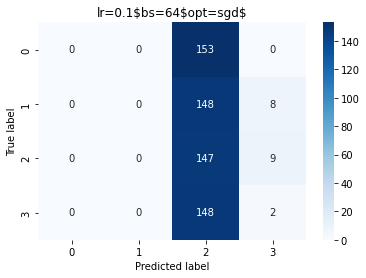

__________________________________________________________


In [41]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
tp = TrainPipeline(model_name='ResNetEmbedder');
test_trackers = tp.random_search_cv(64*64*1, 4, False, False);
model = tp.get_model()
torch.save(model.state_dict(), 'iconip_data/models/resnet18_model_weights.pth')

In [51]:
device = 'cuda:1'
# w = torch.FloatTensor(2,3).cuda(1)
# w=None
w = torch.FloatTensor(2,3).to(device)
w.device

device(type='cuda', index=1)

In [53]:
op_embs = []
op_labels = []
train_op_embs = []
train_op_labels = []

with torch.no_grad():
    tp.get_model().to(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=0)
    for j, testdata in enumerate(testloader):
        tinputs, tlabels = testdata
        tlabels = tlabels.type(torch.LongTensor)

        tinputs, tlabels = tinputs.to(device), tlabels.to(device)
        op_embs.append(tp.get_embeddings(tinputs))
        op_labels.append(tlabels)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True, num_workers=0)
    for j, traindata in enumerate(trainloader):
        tinputs, tlabels = traindata
        tlabels = tlabels.type(torch.LongTensor)

        tinputs, tlabels = tinputs.to(device), tlabels.to(device)
        train_op_embs.append(tp.get_embeddings(tinputs))
        train_op_labels.append(tlabels)

torch.Size([615, 512])
torch.Size([2057, 512])


In [54]:
op = op_embs[0].cpu().numpy()
op_label = op_labels[0].cpu().numpy()
test_df = pd.DataFrame(op, columns=[str(c) for c in range(512)])
test_df['y'] = op_label
test_df.to_csv('data/test_resnet18emb.csv')
test_df.head()


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [56]:
op = train_op_embs[0].cpu().numpy()
op_label = train_op_labels[0].cpu().numpy()
train_df = pd.DataFrame(op, columns=[str(c) for c in range(512)])
train_df['y'] = op_label
train_df.to_csv('iconip_data/train_resnet18emb.csv')
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


### tSNE plots for train and test set ResNet embeddings

In [66]:
df = pd.read_csv('iconip_data/train_resnet18emb.csv')
df.set_index('Unnamed: 0', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(2057, 513)


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Starting t-SNE now!


/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 3.4700093269348145 seconds


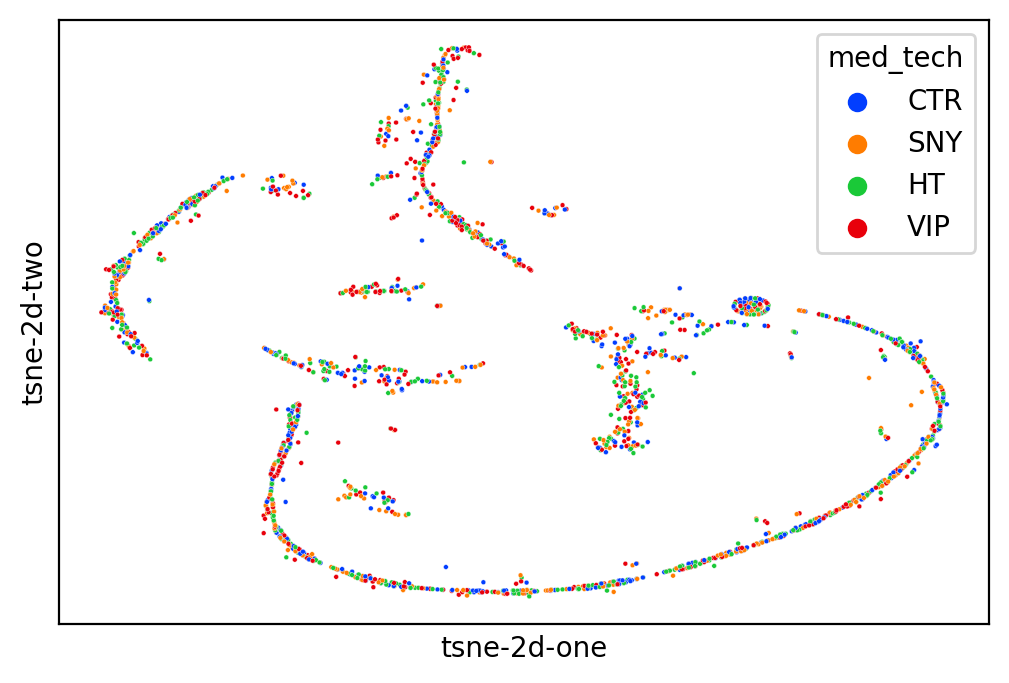

In [67]:
df['med_tech'] = df['y'].apply(convert_medid_to_name)
df_res = df.copy()
feat_columns = [str(c) for c in range(0, 512)] 
data_for_tsne = df_res[feat_columns].values

print("Starting t-SNE now!")
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50)#, n_iter=251)
tsne_results = tsne.fit_transform(data_for_tsne)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_res['tsne-2d-one'] = tsne_results[:,0]
df_res['tsne-2d-two'] = tsne_results[:,1]
#return df_res

fig, axs = plt.subplots(1, 1, sharey=True,dpi=200)
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="med_tech", palette = sns.color_palette("bright", 4),
                data=df_res,legend="full", s=3)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/resnettsne_train_crosscheck.png", bbox_inches='tight', pad_inches=0.05)

In [68]:
df = pd.read_csv('data/test_resnet18emb.csv')
df.set_index('Unnamed: 0', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(615, 513)


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Starting t-SNE now!


/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 1.2927463054656982 seconds


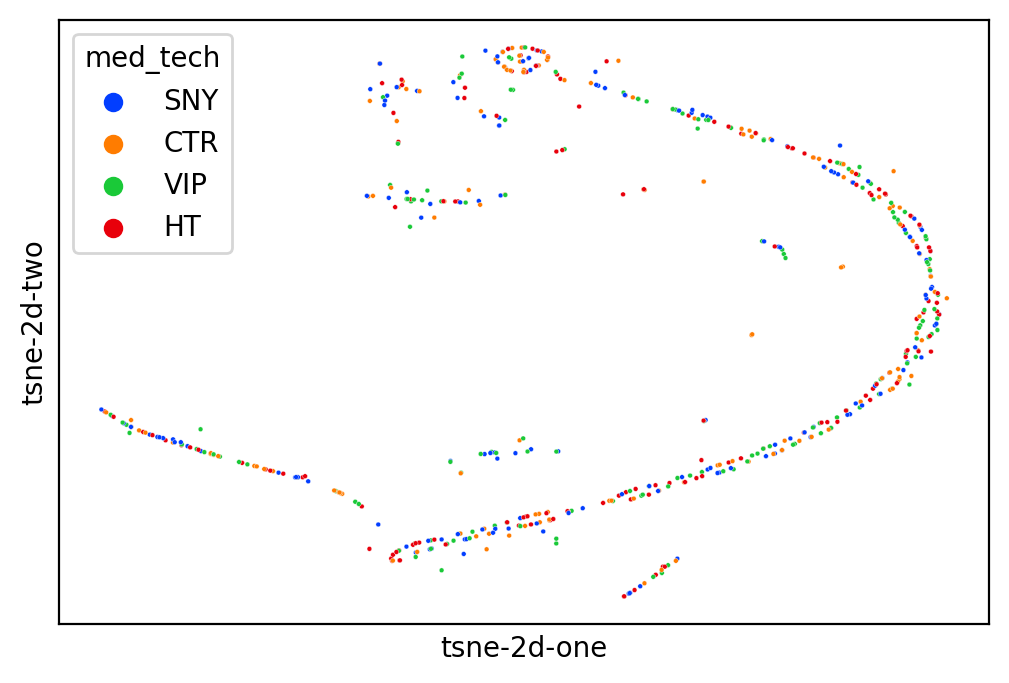

In [69]:
df['med_tech'] = df['y'].apply(convert_medid_to_name)
df_res = df.copy()
feat_columns = [str(c) for c in range(0, 512)] 
data_for_tsne = df_res[feat_columns].values

print("Starting t-SNE now!")
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50)#, n_iter=251)
tsne_results = tsne.fit_transform(data_for_tsne)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_res['tsne-2d-one'] = tsne_results[:,0]
df_res['tsne-2d-two'] = tsne_results[:,1]
#return df_res

fig, axs = plt.subplots(1, 1, sharey=True,dpi=200)
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="med_tech", palette = sns.color_palette("bright", 4),
                data=df_res,legend="full", s=3)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/resnettsne_test_crosscheck.png", bbox_inches='tight', pad_inches=0.05)

batch_size: 64  lr: 0.1
epoch: 0 train_correct: 508 train_correct_acc: 0.24696159455517744 train_loss: 73.33528292179108 val_correct: 153 val_correct_acc: 0.24247226624405704 val_loss: 7651.393615722656
batch_size: 64  lr: 0.1
epoch: 1 train_correct: 479 train_correct_acc: 0.2328633932912008 train_loss: 57.392412543296814 val_correct: 156 val_correct_acc: 0.24722662440570523 val_loss: 113.76397037506104
batch_size: 64  lr: 0.1
epoch: 2 train_correct: 500 train_correct_acc: 0.24307243558580457 train_loss: 52.56391155719757 val_correct: 168 val_correct_acc: 0.2662440570522979 val_loss: 36.53088712692261
batch_size: 64  lr: 0.1
epoch: 3 train_correct: 522 train_correct_acc: 0.25376762275158 train_loss: 51.03978478908539 val_correct: 163 val_correct_acc: 0.2583201267828843 val_loss: 287.07369804382324
batch_size: 64  lr: 0.1
epoch: 4 train_correct: 533 train_correct_acc: 0.25911521633446766 train_loss: 47.52096140384674 val_correct: 143 val_correct_acc: 0.2266244057052298 val_loss: 17.9933

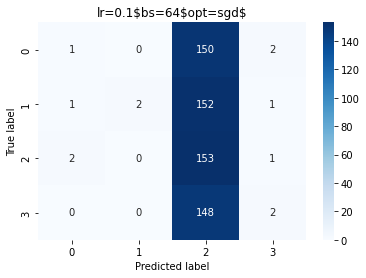

__________________________________________________________
torch.Size([615, 512])


In [11]:
op_embs_labels = get_embeddings()

In [12]:
len(op_embs_labels[0]), op_embs_labels[0][0].shape

(1, torch.Size([615, 512]))

In [16]:
op = op_embs_labels[0][0].cpu().numpy()
op_label = op_embs_labels[1][0].cpu().numpy()

In [20]:
op.shape, op_label.shape

((615, 512), (615,))

In [18]:
df = pd.DataFrame(op, columns=[str(c) for c in range(512)])

In [21]:
df['y'] = op_label
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015713,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,3
1,0.0,0.0,0.000411,0.0,0.0,0.0,0.014868,0.0,0.158139,0.0,...,0.0,0.0,0.0,0.0,0.06417,0.0,0.0,0.0,0.011832,2
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015681,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015739,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,1
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015707,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,3


In [23]:
df.to_csv('data/resnet18emb.csv')

In [27]:
import time
from sklearn.manifold import TSNE

In [31]:
def convert_medid_to_name(x):
    all_names = ["HT", "SNY", "VIP", "CTR"]
    return all_names[x]

Starting t-SNE now!


/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/singh_shruti/anaconda3/envs/torchenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 1.3653557300567627 seconds


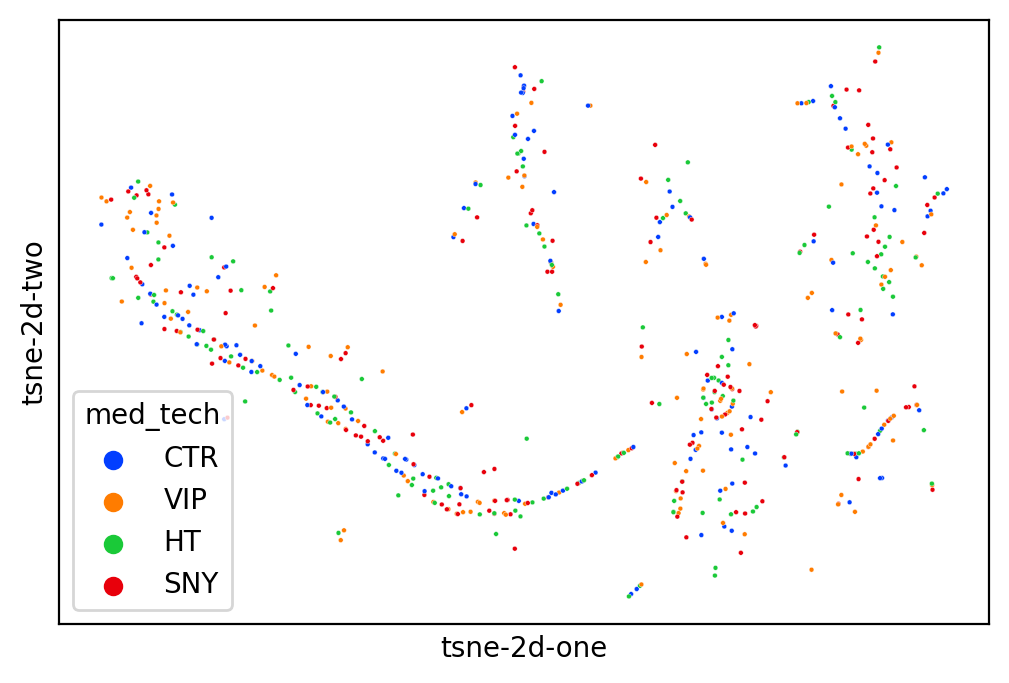

In [32]:
df['med_tech'] = df['y'].apply(convert_medid_to_name)
df_res = df.copy()
feat_columns = [str(c) for c in range(0, 512)] 
data_for_tsne = df_res[feat_columns].values

print("Starting t-SNE now!")
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50)#, n_iter=251)
tsne_results = tsne.fit_transform(data_for_tsne)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_res['tsne-2d-one'] = tsne_results[:,0]
df_res['tsne-2d-two'] = tsne_results[:,1]
#return df_res

fig, axs = plt.subplots(1, 1, sharey=True,dpi=200)
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="med_tech", palette = sns.color_palette("bright", 4),
                data=df_res,legend="full", s=3)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/resnettsne.png", bbox_inches='tight', pad_inches=0.05)

### 1. ResNet18

In [ ]:
tp = TrainPipeline(model_name='ResNet')
test_trackers = tp.random_search_cv(64*64*1, 4, False, False)

In [79]:
test_trackers

{'lr=0.001$bs=16$opt=sgd$': 0.23739837398373984,
 'lr=0.001$bs=16$opt=adam$': 0.2764227642276423,
 'lr=0.001$bs=64$opt=sgd$': 0.24715447154471545,
 'lr=0.001$bs=64$opt=adam$': 0.24227642276422764,
 'lr=0.001$bs=128$opt=sgd$': 0.24715447154471545,
 'lr=0.001$bs=128$opt=adam$': 0.24715447154471545,
 'lr=0.01$bs=16$opt=sgd$': 0.25365853658536586,
 'lr=0.01$bs=16$opt=adam$': 0.24878048780487805,
 'lr=0.01$bs=64$opt=sgd$': 0.22439024390243903,
 'lr=0.01$bs=64$opt=adam$': 0.25853658536585367,
 'lr=0.01$bs=128$opt=sgd$': 0.25203252032520324,
 'lr=0.01$bs=128$opt=adam$': 0.25203252032520324,
 'lr=0.1$bs=16$opt=sgd$': 0.24878048780487805,
 'lr=0.1$bs=16$opt=adam$': 0.25365853658536586,
 'lr=0.1$bs=64$opt=sgd$': 0.25203252032520324,
 'lr=0.1$bs=64$opt=adam$': 0.25365853658536586,
 'lr=0.1$bs=128$opt=sgd$': 0.25203252032520324,
 'lr=0.1$bs=128$opt=adam$': 0.24878048780487805}

### 2. VGG11

In [ ]:
tp_vgg = TrainPipeline(model_name='VGGNet')
test_trackers_vgg = tp_vgg.random_search_cv(64*64*1, 4, False, False)

In [105]:
test_trackers_vgg

{'lr=0.001$bs=16$opt=sgd$': 0.25365853658536586,
 'lr=0.001$bs=16$opt=adam$': 0.24878048780487805,
 'lr=0.001$bs=64$opt=sgd$': 0.24715447154471545,
 'lr=0.001$bs=64$opt=adam$': 0.24878048780487805,
 'lr=0.001$bs=128$opt=sgd$': 0.25365853658536586,
 'lr=0.001$bs=128$opt=adam$': 0.23414634146341465,
 'lr=0.01$bs=16$opt=sgd$': 0.23089430894308943,
 'lr=0.01$bs=16$opt=adam$': 0.24878048780487805,
 'lr=0.01$bs=64$opt=sgd$': 0.25365853658536586,
 'lr=0.01$bs=64$opt=adam$': 0.25365853658536586,
 'lr=0.01$bs=128$opt=sgd$': 0.24878048780487805,
 'lr=0.01$bs=128$opt=adam$': 0.24878048780487805,
 'lr=0.1$bs=16$opt=sgd$': 0.25365853658536586,
 'lr=0.1$bs=16$opt=adam$': 0.25365853658536586,
 'lr=0.1$bs=64$opt=sgd$': 0.25365853658536586,
 'lr=0.1$bs=64$opt=adam$': 0.25365853658536586,
 'lr=0.1$bs=128$opt=sgd$': 0.25365853658536586,
 'lr=0.1$bs=128$opt=adam$': 0.25365853658536586}